# Prédiction du type de culture en fonction du sol et de la météo
<br>
<span style='font-size:20px'><center>
<blockquote cite="https://www.kaggle.com/code/theeyeschico/crop-analysis-and-prediction/input">Precision agriculture is in trend nowadays. It helps the farmers to get informed decision about the farming strategy. Here, I present you a dataset which would allow the users to build a predictive model to recommend the most suitable crops to grow in a particular farm based on various parameters.  This dataset was build by augmenting datasets of rainfall, climate and fertilizer data available for India.</center></blockquote>
<a href='https://www.kaggle.com/code/theeyeschico/crop-analysis-and-prediction/input'> https://www.kaggle.com/code/theeyeschico/crop-analysis-and-prediction/input </a>
 </span> 


 <span style='font-size:20px'><center>
Le but est de prédire (recommender) un type de culture en utilisant les données météo et de composition du sol. 
La tâche est une tâche de classification, le type de culture est l'étiquette.  Nous nous déplaçons dans une autre partie du monde, en Inde.
    
</span>

## Installation et chargement des librairies nécessaires

Nous devons d'abord charger (et possiblement installer) les librairies nécessaires.  Voici une description de certaines des librairies utilisées.

- `missingo` permet de visualiser rapidement les données manquantes
- `sklearn`  scikit-learn est un incontournable pour faire de l'apprentissage automatique
- `matplotlib` et `seaborn` pour générer des graphiques
- `numpy` pour des opérations d'algèbres linéaires et mathématiques
- `pandas` pour faciliter la manipulation et la structure des données (parfois lent pour les gros jeux de données)


In [1]:
#!pip install missingno
#!pip install statsmodels
#!pip install scikit-learn 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math


import missingno
import statsmodels.api as sm

from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier, BaggingRegressor,
                              GradientBoostingRegressor, GradientBoostingClassifier)
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.datasets import make_regression
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score, f1_score, mean_absolute_error,
                            confusion_matrix, classification_report, roc_auc_score, recall_score)


sns.set(font_scale=0.9, style='whitegrid')
colors = ["#40BEAD", "#248CC4", "#308E81", "#576AC9"] # IVADO palette

## Chargement du jeu de données

In [2]:
file_id = '1Q0_iIK26HzapTIEAj4kDCHoMj1gowNyQ'
google_url_format = "https://drive.google.com/uc?export=view&id=%s"
myfile = google_url_format % file_id 
mf = pd.read_csv(myfile)
mf['label'] = mf.label.astype('category')

Regardons les données

In [3]:
mf.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


Le jeu de données contient les caractéristiques suivantes: 
    
* N - ratio of Nitrogen content in soil
* P - ratio of Phosphorous content in soil
* K - ratio of Potassium content in soil
* temperature - temperature in degree Celsius
* humidity - relative humidity in %
* ph - ph value of the soil
* rainfall - rainfall in mm

## À votre tour  
<span class='h1'> Break room - 10 min - en équipe </h4>


<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

Explorer les données à l'aide de graphiques et de tableaux (1-2 graphique(s))

Suggestions : 
* Pairplot de seaborn
* Graphique de distribution
* Nombre de valeurs manquantes 


Qu'avez-vous observé ?

<h3> Nombre de valeurs manquantes </h3>

Cela nous indique si nous devons ajouter une étape d'imputation des valeurs manquantes.

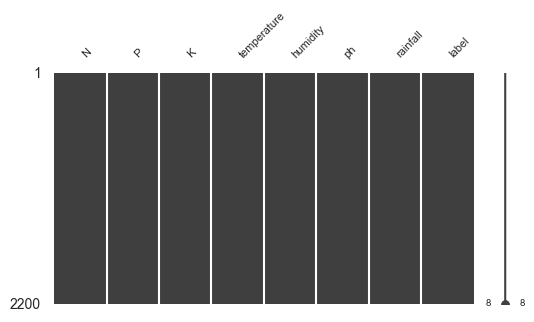

In [4]:
missingno.matrix(mf, figsize=(6,3), fontsize=8)
plt.show()

<h3> Nombre d'exemples par classe </h3>

Cela nous indique si les classes sont bien balancées. Lorsque les classes sont débalancées, nous devons nous assurer d'ajuster notre *baseline* et notre définition de succès.  Nous devons aussi prendre des précautions au niveau de la validation croisée.
<center>
<img src='https://user.oc-static.com/upload/2017/02/27/14881893858847_P2C2-3.png' width='400px'/> </center>


<a style='font-size:16px;' href='https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/4308241-mettez-en-place-un-cadre-de-validation-croisee'>https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/4308241-mettez-en-place-un-cadre-de-validation-croisee</a>


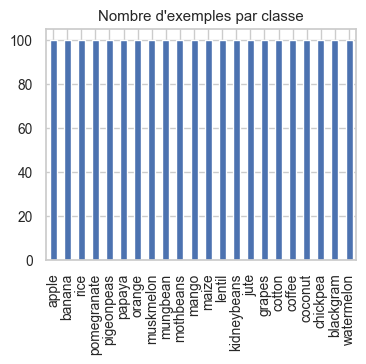

In [5]:
plt.figure(figsize=(4,3))
mf.label.value_counts().plot(kind='bar', title="Nombre d'exemples par classe")
plt.show()

<h3> Valeur moyenne de chaque caractéristique par classe </h3>

Cela nous donne une idée de la variabilité pour chacune des classes.  Par exemple, nous pouvons tout de suite présumer que le ph sera peu informatif et peu utile pour discriminer les différentes sortes de cultures.

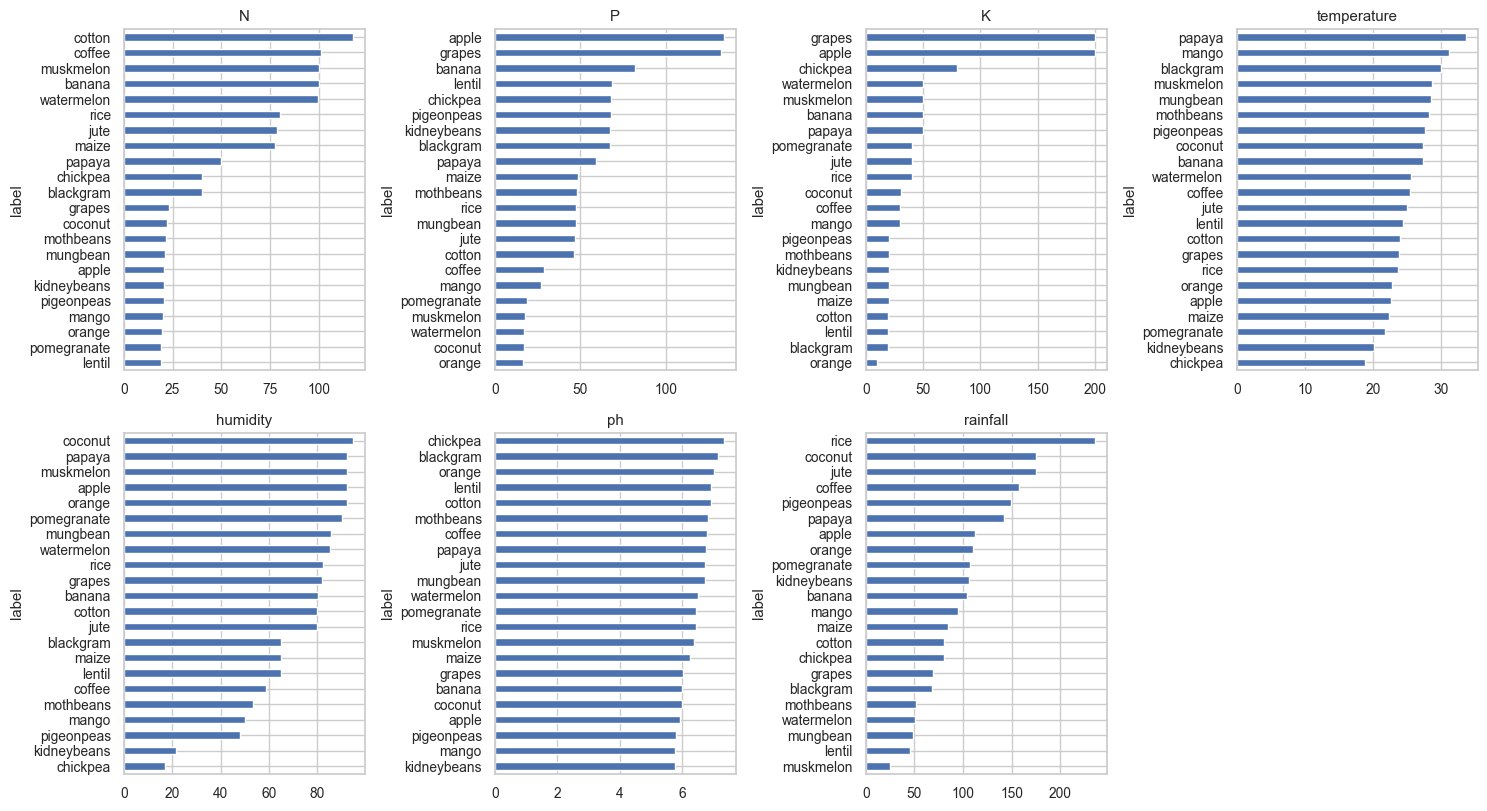

In [6]:
nc = 4
nr = math.ceil((mf.shape[1]/nc)+1)
g = mf.groupby('label')
fig = plt.figure(figsize=(15,12))
for i,col in enumerate(list(mf.columns)): 
    if col=='label':
        continue
    plt.subplot(nr,nc,i+1)
    g.mean()[col].sort_values().plot(kind='barh', title=col) 
plt.tight_layout()
plt.show()

### Visualisation par radar plot

Nous permet de comparer directement plusieurs classes en regardant des caractérisitques choisies.  Cette visualisation s'avère utile pour les petits jeux de données.

In [7]:
#https://www.pythoncharts.com/matplotlib/radar-charts/
def radarplot(crop, color='doderblue', ax=None):
    g = mf.groupby('label').mean()
    features = g.columns
    # Normalisation
    g = (g - g.min(0)) / (g.max(0) - g.min(0))
    values = g.loc[crop, :].values
    num_features = len(features)
    angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
    if ax is None:
        _, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles), features)

    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
   
    ax.set_ylim(0, 1)
    ax.set_rlabel_position(180 / num_features)
    ax.tick_params(colors='#222222')
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(color='#AAAAAA')
    ax.spines['polar'].set_color('#222222')
    ax.set_facecolor('#FAFAFA')
    ax.plot(angles, values, color=color, linewidth=1, label=crop)
    ax.fill(angles, values, color=color, alpha=0.25)
    ax.set_title(F"Caractéristiques", y=1.18)
    return ax

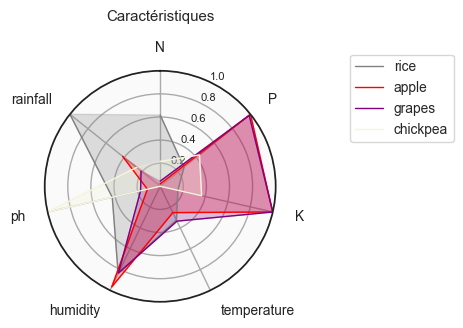

In [8]:
ax = radarplot('rice', color='grey')
ax = radarplot('apple', color='red', ax=ax)
ax = radarplot('grapes', color='purple', ax=ax)
ax = radarplot('chickpea', color='beige', ax=ax)
plt.legend(bbox_to_anchor=(1.8, 1.1))
plt.show()

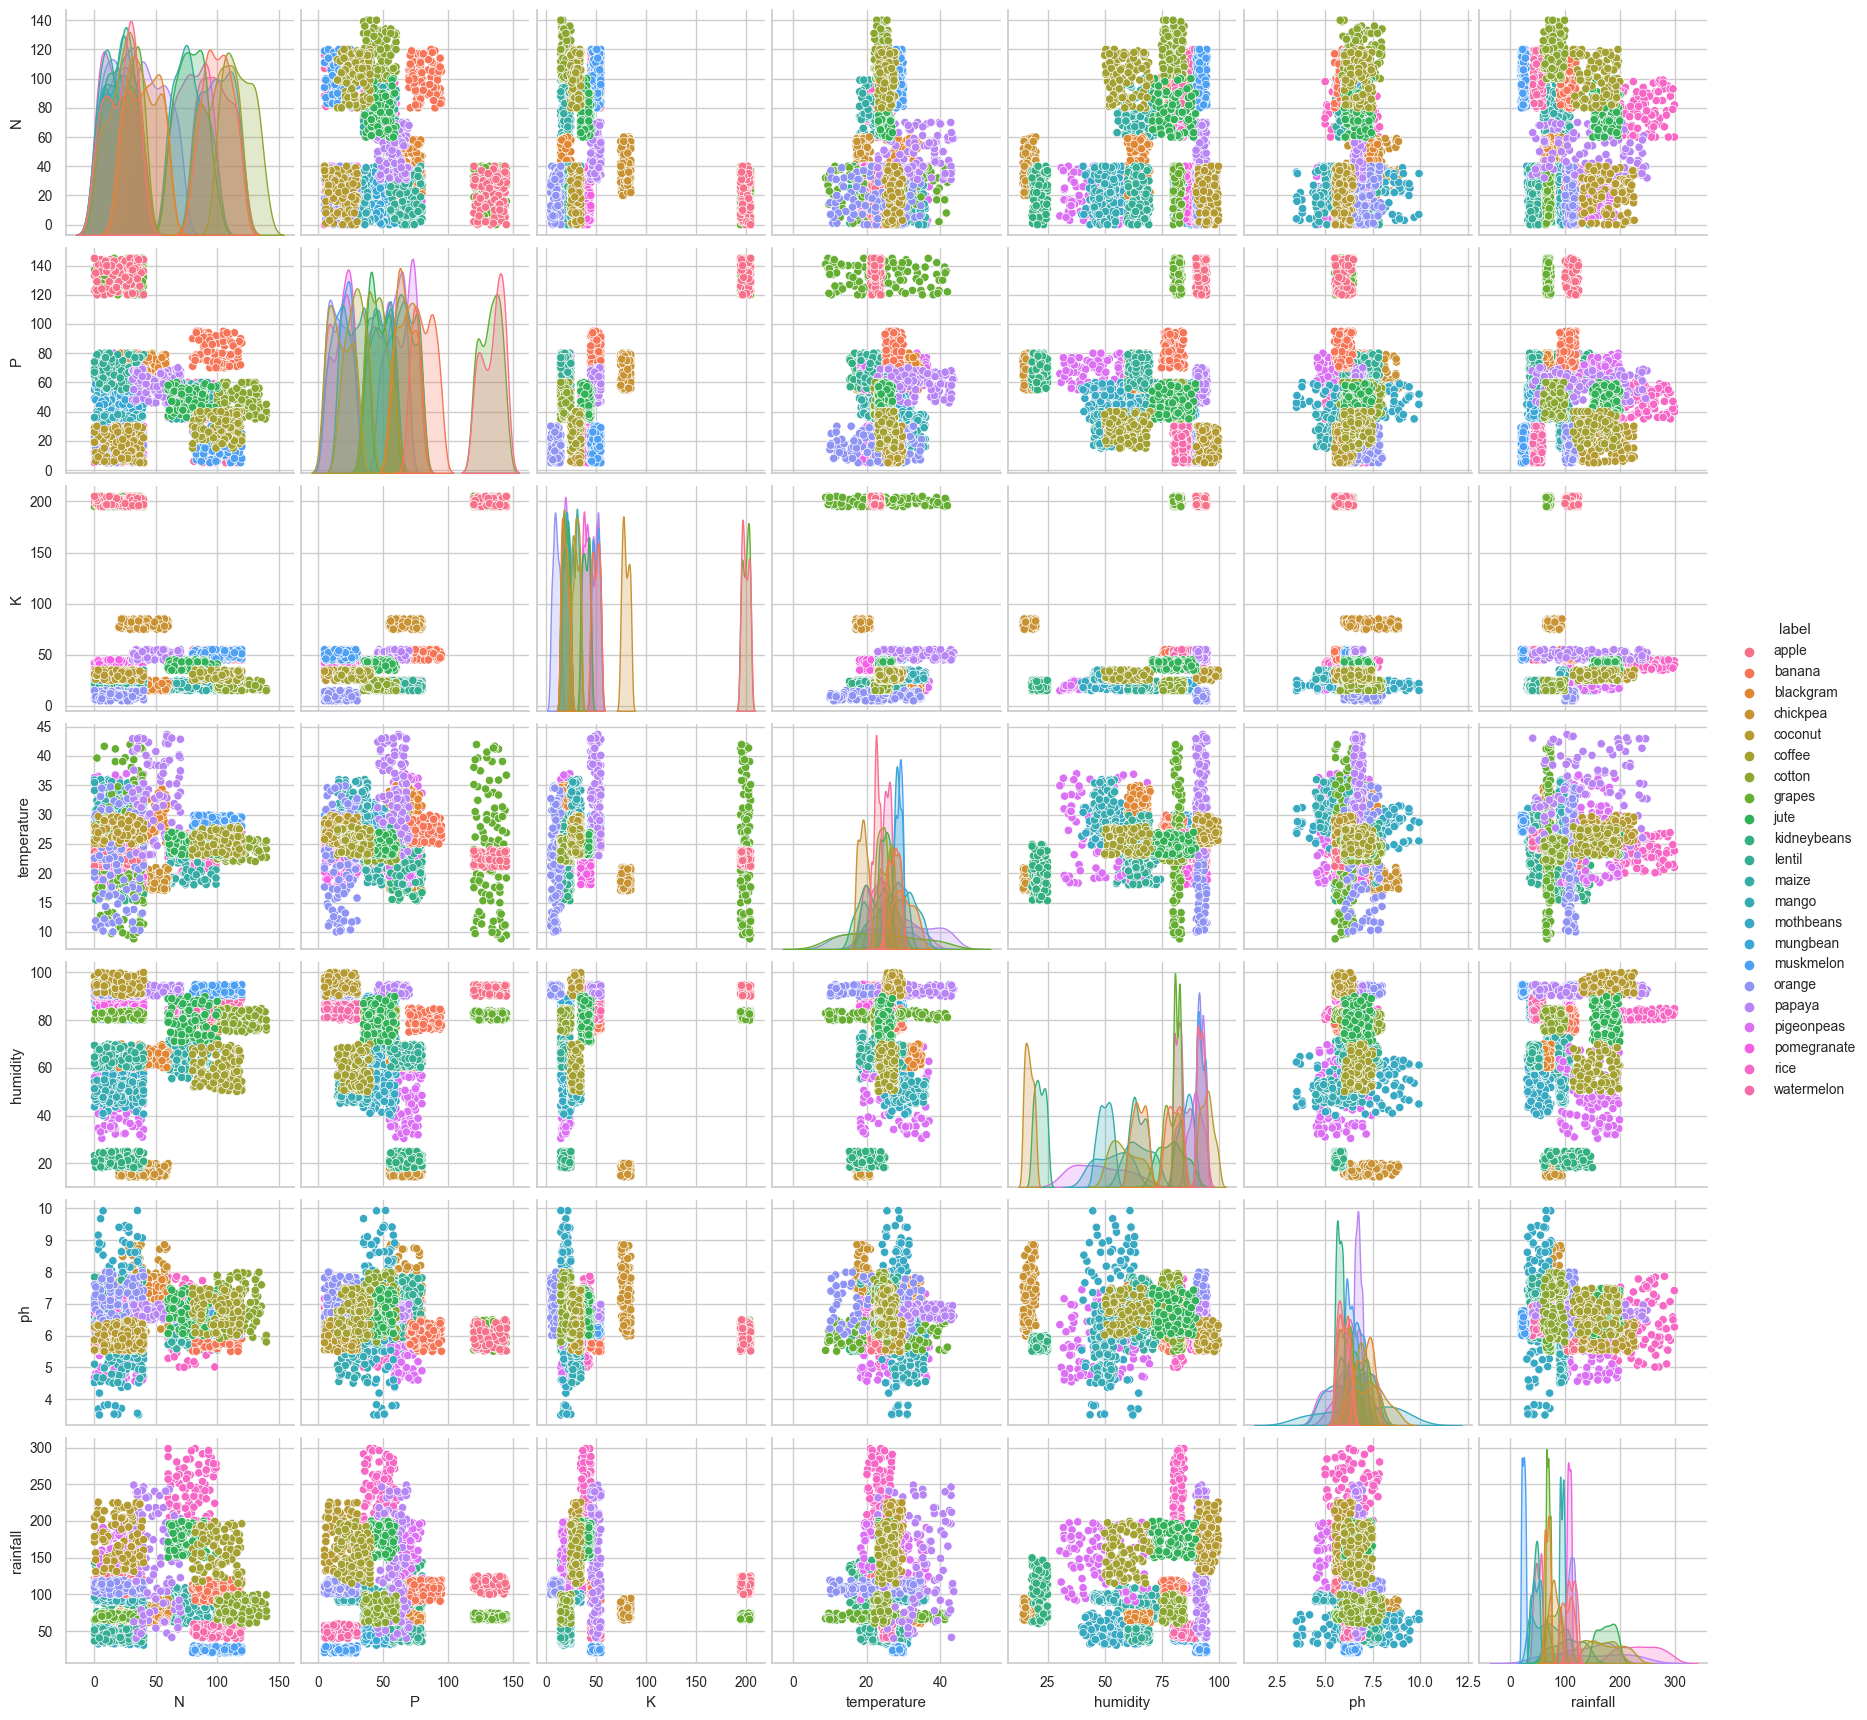

In [9]:
sns.pairplot(mf, hue = 'label')
plt.show()

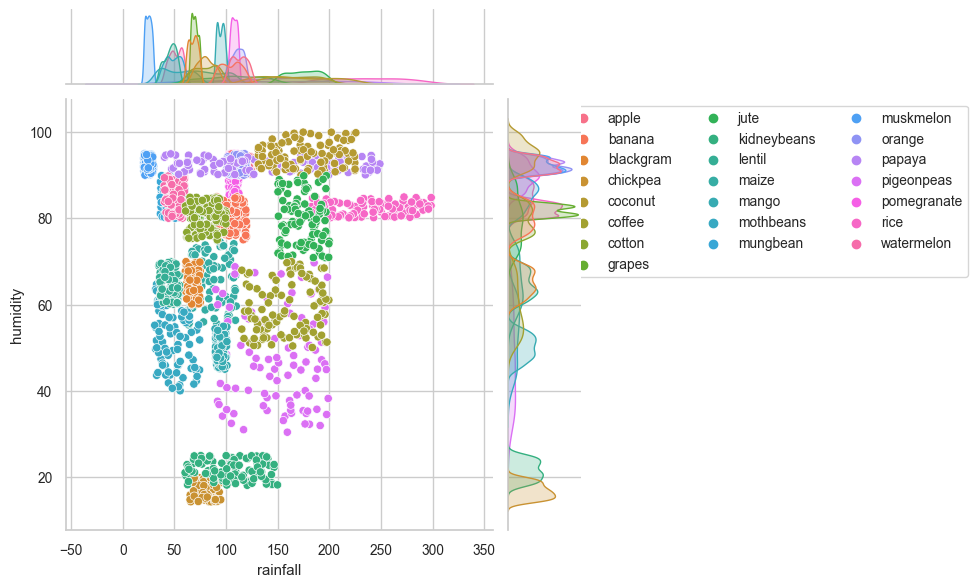

In [10]:
sns.jointplot(x="rainfall", y="humidity", data=mf, hue="label")
plt.legend(bbox_to_anchor=(1.15, 1), ncol=3)
plt.show()

## Classification du type de culture en fonction des donneés du sol et de météo


In [11]:
X = mf.drop('label', axis=1)
y = mf.label.cat.codes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

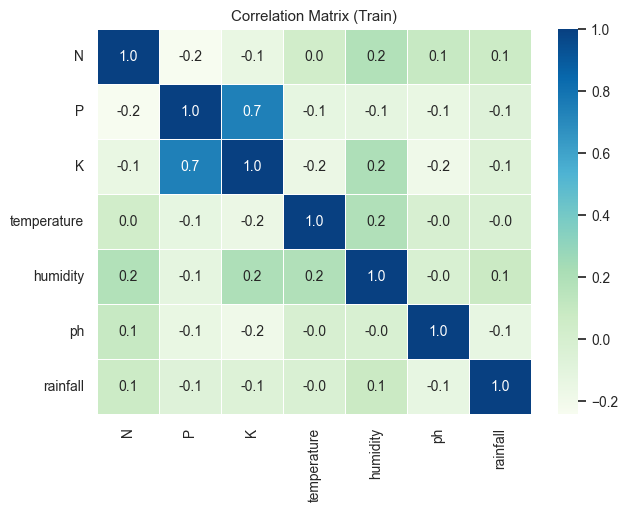

In [12]:
plt.figure(figsize=(7,5))
sns.heatmap(X_train.corr(), annot=True, fmt=".1f", cmap='GnBu', linewidths=.5, annot_kws={"size": 10}).set(title='Correlation Matrix (Train)')
plt.show()

### Recherche du meilleur modèle et de ses paramètres

In [13]:
# environ 2-3 min
estimator_params = {'RandomForestClassifier': {'estimator__max_depth': [4, 6, 8, 10, 12]},
                    'SVC' : {'estimator__kernel':  ['poly', 'rbf', 'sigmoid']},
                    'DecisionTreeClassifier': {},
                    'KNeighborsClassifier':{},
                    'DummyClassifier': {}                      
}

res = []
for estimator in estimator_params.keys():
    parameters = {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'imputer': [SimpleImputer(), IterativeImputer()],
    }
    pipeline = Pipeline([
        ('imputer', None), ('scaler', None), ('estimator', eval(estimator)()) 
    ])
    parameters.update(estimator_params.get(estimator, {}))
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring="accuracy")  
    grid_search.fit(X_train, y_train) 
    cv_results = grid_search.cv_results_
    best_estimator = grid_search.best_estimator_     
    res.append([estimator, grid_search.best_score_, grid_search.best_params_, cv_results, best_estimator]) 
res = pd.DataFrame(res, columns=['Model', 'Best_Score', 'Best_parameters', 'CV_Results', 'Best_estimator'])

Regardons les résultats obtenus

In [14]:
res

,Model,Best_Score,Best_parameters,CV_Results,Best_estimator
0,RandomForestClassifier,0.996023,"{'estimator__max_depth': 12, 'imputer': Iterat...","{'mean_fit_time': [0.24788899421691896, 0.2135...","(IterativeImputer(), MinMaxScaler(), (Decision..."
1,SVC,0.985795,"{'estimator__kernel': 'poly', 'imputer': Simpl...","{'mean_fit_time': [0.0313530445098877, 0.01546...","(SimpleImputer(), MinMaxScaler(), SVC(kernel='..."
2,DecisionTreeClassifier,0.986364,"{'imputer': IterativeImputer(), 'scaler': Stan...","{'mean_fit_time': [0.009926080703735352, 0.009...","(IterativeImputer(), StandardScaler(), Decisio..."
3,KNeighborsClassifier,0.982955,"{'imputer': SimpleImputer(), 'scaler': RobustS...","{'mean_fit_time': [0.00535430908203125, 0.0044...","(SimpleImputer(), RobustScaler(), KNeighborsCl..."
4,DummyClassifier,0.050568,"{'imputer': SimpleImputer(), 'scaler': Standar...","{'mean_fit_time': [0.0039484500885009766, 0.00...","(SimpleImputer(), StandardScaler(), DummyClass..."


### Comparaison des modèles 

Nous pouvons utiliser le `Best_score` pour identifier le meilleur modèle.  Il est intéressant de regarder plusieurs métriques car chacune des métriques nous renseigne sur des aspects différents.  Nous devons aussi considérer les contraintes pratiques dans notre choix, comme par exemple le temps d'exécution.

In [15]:
metric_names = ["accuracy_score", "recall_score"] # même nom que dans la librairie
mymetrics = []
for row in res.to_dict('records'):
    model = row['Model']
    time = row['CV_Results']['mean_fit_time'].mean()+row['CV_Results']['mean_score_time'].mean()
    estimator = row['Best_estimator']
    pred_test = estimator.fit(X_train, y_train).predict(X_test)
    m = []
    for metric_name in metric_names:
        try:
            m.append(eval(f'{metric_name}(y_test, pred_test)'))    
        except:
            m.append(eval(f'{metric_name}(y_test, pred_test, average="weighted")'))  
    mymetrics.append([model, time ] + m)
mymetrics =  pd.DataFrame(mymetrics, columns=['Model', 'Time'] + metric_names)

In [16]:
# Regardons les valeurs des métriques
mymetrics

,Model,Time,accuracy_score,recall_score
0,RandomForestClassifier,0.293582,0.993182,0.993182
1,SVC,0.082220,0.963636,0.963636
2,DecisionTreeClassifier,0.017775,0.988636,0.988636
3,KNeighborsClassifier,0.024328,0.965909,0.965909
4,DummyClassifier,0.011536,0.025000,0.025000


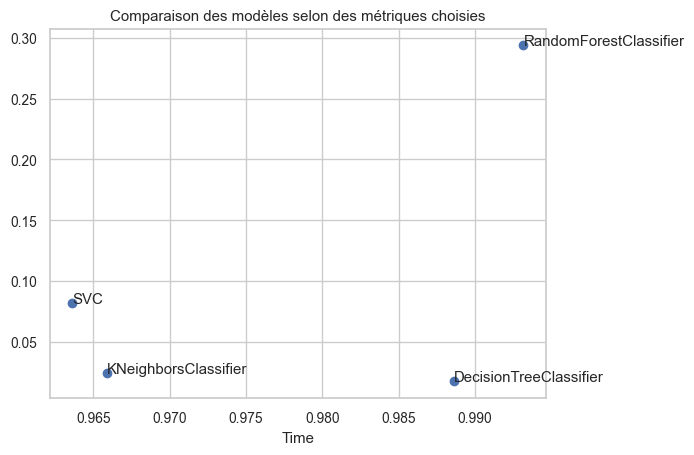

In [17]:
vars = ["accuracy_score", "Time"]
mx = mymetrics.iloc[:-1,:]
px = mx[vars[0]]
py = mx[vars[1]]
plt.scatter(px, py)
for i in range(len(px)):
    plt.text(px[i], py[i], s=mx.Model[i])
plt.xlabel(F'{vars[0].split("_")[0].title()}')
plt.xlabel(F'{vars[1].split("_")[0].title()}')
plt.title('Comparaison des modèles selon des métriques choisies')
plt.show()

Nous pouvons regarder la matrice de confusion d'un modèle en particulier

In [18]:
classifier = res.loc[res.Model=='RandomForestClassifier', 'Best_estimator'][0]
classifier.fit(X_train, y_train)
test_score = classifier.score(X_test, y_test)
y_pred = classifier.predict(X_test)
print(F'RandomForestClassifier {test_score:3.3}')
print(classification_report(y_test, y_pred, target_names=mf.label.cat.categories))

RandomForestClassifier 0.993
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00        1

Regardons maintenant les caractéristiques les plus importantes pour le modèle `RandomForestClassifier``

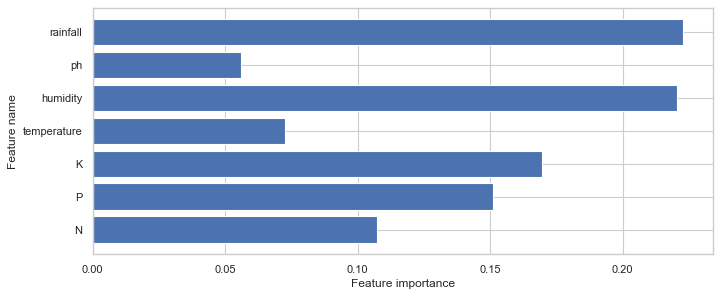

In [19]:
plt.figure(figsize=(10,4), dpi=80)
c_features = len(X_train.columns)
plt.barh(range(c_features), classifier.steps[2][1].feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train.columns)
plt.show()

Il est utile de créer quelques fonctions pour visualiser les résultats obtenus.  Cela nous aide à évaluer la qualité des prédictions.

In [20]:
def plot_probabilities_heatmap(X_test, classifier, labels):
    sns.heatmap(classifier.predict_proba(X_test), cmap='viridis', xticklabels=labels, 
                yticklabels=False, cbar=True).set(title='Predicted Probabilities')
    plt.show()
    
def plot_probalities_points(X_test, classifier, labels):
    sns.set(font_scale=0.9, style='whitegrid')
    tmp = pd.DataFrame(classifier.predict_proba(X_test), columns=labels)
    ix = tmp.quantile(0.90, 0).sort_values()
    tmp = tmp.loc[:, ix.index]
    sns.catplot(data=tmp, height=4, aspect=1.6, palette='tab20b').set(title='Predicted Probabilities')
    plt.xticks(rotation=90)
    plt.show()

In [21]:
def plot_confusion_matrix(X_test, y_test, classifier, labels):
    mat = confusion_matrix(y_test, classifier.predict(X_test))
    df_cm = pd.DataFrame(mat, list(labels), list(labels))
    sns.set(font_scale=1.0) # for label size
    fig, ax = plt.subplots(figsize=(8,5)) 
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap="terrain", ax=ax).set(title='Confusion Matrix')
    plt.show()

Regardons maintenant les résultats de notre modèle

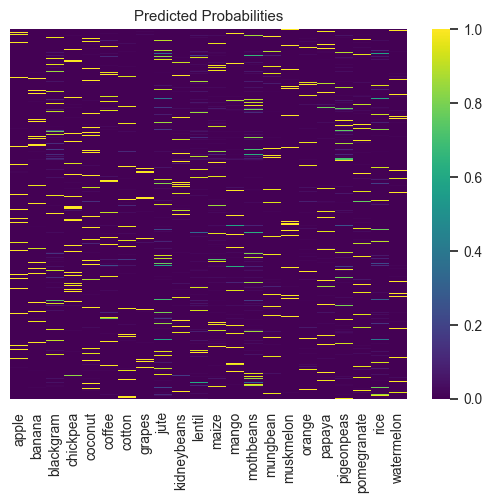

In [22]:
plot_probabilities_heatmap(X_test, classifier, labels=mf.label.cat.categories)

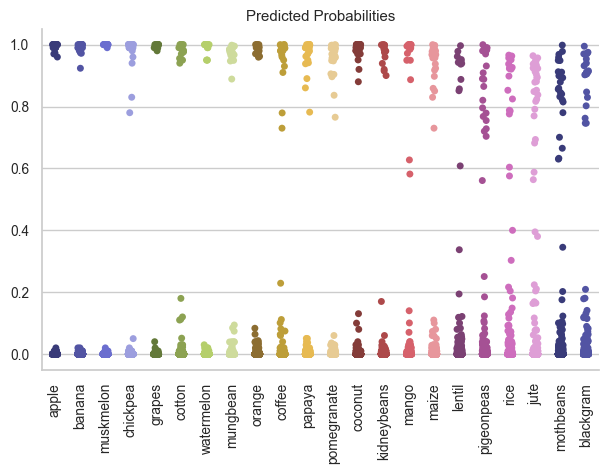

In [23]:
plot_probalities_points(X_test, classifier, labels=mf.label.cat.categories)

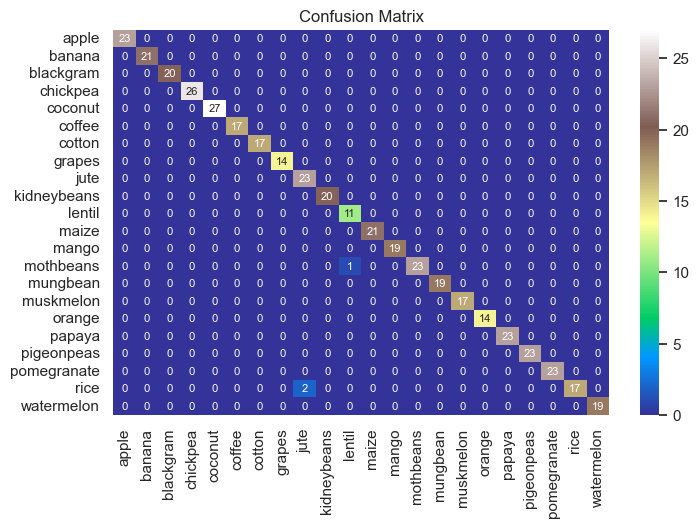

In [24]:
plot_confusion_matrix(X_test, y_test, classifier, labels=mf.label.cat.categories)

### À votre tour  
<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

Que concluez-vous de ces graphiques?

L'exactitude est souvent rapportée comme métrique pour les tâches de classification.  Cela nous indique la proportion d'exemples qui ont été bien prédits, i.e. combien de prédictions sont correctes. 

Attention, par contre, aux jeux de données où les classes ne sont pas bien balancées.



La courbe ROC présente la sensibilité (True Positive Rate - TPR) en fonction de 1 - spécificité (False positive rate - FPR).  Elle permet aussi de comparer différents modèles.

<a title="MartinThoma, CC0, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Roc-draft-xkcd-style.svg"><img width="512" alt="Roc-draft-xkcd-style" src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/Roc-draft-xkcd-style.svg/512px-Roc-draft-xkcd-style.svg.png"></a>

In [25]:
res.head()

,Model,Best_Score,Best_parameters,CV_Results,Best_estimator
0,RandomForestClassifier,0.996023,"{'estimator__max_depth': 12, 'imputer': Iterat...","{'mean_fit_time': [0.24788899421691896, 0.2135...","(IterativeImputer(), MinMaxScaler(), (Decision..."
1,SVC,0.985795,"{'estimator__kernel': 'poly', 'imputer': Simpl...","{'mean_fit_time': [0.0313530445098877, 0.01546...","(SimpleImputer(), MinMaxScaler(), SVC(kernel='..."
2,DecisionTreeClassifier,0.986364,"{'imputer': IterativeImputer(), 'scaler': Stan...","{'mean_fit_time': [0.009926080703735352, 0.009...","(IterativeImputer(), StandardScaler(), Decisio..."
3,KNeighborsClassifier,0.982955,"{'imputer': SimpleImputer(), 'scaler': RobustS...","{'mean_fit_time': [0.00535430908203125, 0.0044...","(SimpleImputer(), RobustScaler(), KNeighborsCl..."
4,DummyClassifier,0.050568,"{'imputer': SimpleImputer(), 'scaler': Standar...","{'mean_fit_time': [0.0039484500885009766, 0.00...","(SimpleImputer(), StandardScaler(), DummyClass..."


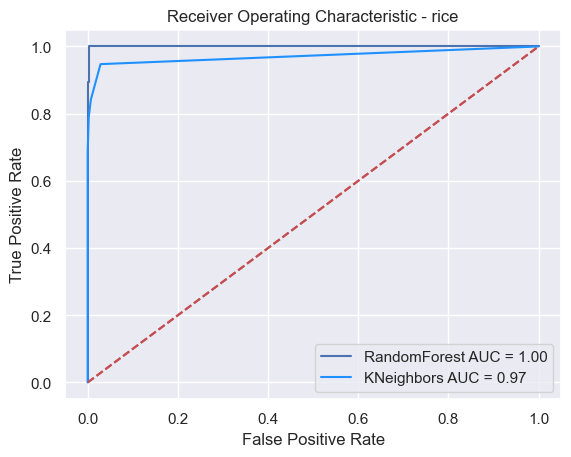

In [26]:
from sklearn.metrics import auc, roc_curve
i = 20 
category = mf.label.cat.categories[i]
y_test_i = y_test==i

probs = classifier.predict_proba(X_test)
preds = probs[:,i]
fpr, tpr, threshold = roc_curve(y_test_i, preds)
roc_auc = auc(fpr, tpr)
plt.title(f'Receiver Operating Characteristic - {category}')
plt.plot(fpr, tpr, 'b', label = 'RandomForest AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


classifier2 = res.loc[res.Model=='KNeighborsClassifier', 'Best_estimator'].values[0]
probs = classifier2.predict_proba(X_test)
preds = probs[:,i]
fpr, tpr, threshold = roc_curve(y_test_i, preds)
roc_auc = auc(fpr, tpr)
plt.title(f'Receiver Operating Characteristic - {category}')
plt.plot(fpr, tpr, label = 'KNeighbors AUC = %0.2f' % roc_auc, color='dodgerblue'
)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Quelques notebooks utilisant le même jeu de données

Pas toujours parfaits, mais c'est utile de lire le code des autres pour apprendre et se garder à jour.

* https://www.kaggle.com/code/altafk/real-time-crop-recommendation
* https://www.kaggle.com/code/ysthehurricane/crop-recommendation-system-using-lightgbm
* https://www.kaggle.com/code/atharvaingle/what-crop-to-grow
* https://github.com/the-pinbo/crop-prediction